# Определение возраста покупателей по  фото

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy  as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from  tensorflow import keras
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.applications.resnet import ResNet50 # type: ignore

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

Загрузим label.csv из папки `/datasets/faces/`и ознокомимся с данными:

In [2]:
df_labels =pd.read_csv('/datasets/faces/labels.csv')
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


DataFrame `df_labels` содержит два столбца: возраст людей и названия файлов, соответствующих фотографиям этих людей.
Проверим наличие дубликатов  в столбце `file_name`.

In [4]:
print(f'количество дублтикатов в столбце file_name: {df_labels["file_name"].duplicated().sum()}.')

количество дублтикатов в столбце file_name: 0.


Дубликаты не обнаружены, названия файлов уникальны.

Рассчитаем описательные статистики для  столбца `real_age`,  построим график распределения и боксплот.

In [5]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [1]:
gist_titl='Столбчатый график'
box_titl='Ящик с усами'
total_titl='Распределение и боксплот  столбца  "real_age "'

pivot_age =df_labels.pivot_table(index='real_age', values='real_age', aggfunc='count')    
    
fig_bar = px.bar(pivot_age)
fig_box = px.box(y=df_labels['real_age'])

# Создание фигуры и размещение на ней графиков.
fig = make_subplots(rows=1, cols=2,subplot_titles=(gist_titl, box_titl),column_widths=[0.8, 0.2] )
fig.update_layout(height=400, width=800)
fig.add_trace(fig_bar.data[0], row=1, col=1)
fig.add_trace(fig_box.data[0], row=1, col=2)

fig.update_layout(title=total_titl, title_font_size=20,showlegend=False)
fig.update_xaxes(title_text='Возраст, год', row=1, col=1)
fig.update_xaxes(title_text='', row=1, col=2)  
fig.update_yaxes(title_text='Количество', row=1, col=1)
fig.update_yaxes(title_text='Возраст, год',title_standoff=0, row=1, col=2)
    

Напечатаем график  плотности распределения   KDE для`real_age`

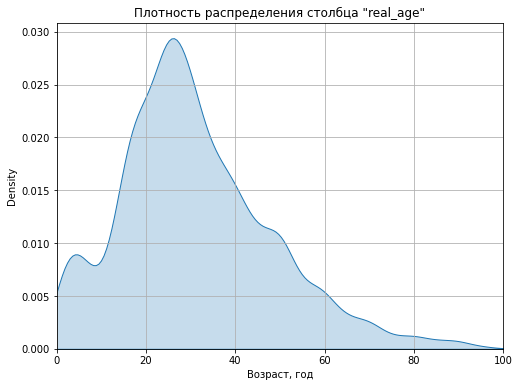

In [7]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df_labels['real_age'], shade=True, color='#1f77b4')


plt.grid(True)

plt.title('Плотность распределения столбца "real_age"')
plt.xlabel('Возраст, год')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.show()

Проанализируем   данные столбца `real_age`- возраст людей на фотографиях.
- Общее количество наблюдений составило 7591.
- Диапазон возрастов в данных колеблется от 1 до 100 лет.
- Среднее значение возраста составляет 31 год, а медиана — 29 лет.
- Стандартное отклонение равно 17 годам. На распределении заметен "тяжёлый" хвост справа, что указывает на наличие возможных выбросов. Это подтверждается также графиком боксплот, который показывает выбросы выше возраста 72 года.
- Стандартное отклонение относительно высокое, что свидетельствует о значительном разбросе данных.

Межквартильный размах (между 25-м и 75-м процентилями) составляет от 20 до 41 лет, что является наиболее подходящим диапазоном для решения задач прогнозирования прогнозирования.

Распечатаем фотографии из каталога. Для этого будем использовать ImageDataGenerator и метод .flow_from_dataframe()

In [8]:
datagen = ImageDataGenerator(rescale=1/255)

path = '/datasets/faces/final_files'
foto_gen = datagen.flow_from_dataframe( 
    dataframe = df_labels,
    directory= path,
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(150,150),
    batch_size=16,
    seed = 50)
                        

Found 7591 validated image filenames.


In [11]:
feature, age = next(foto_gen)

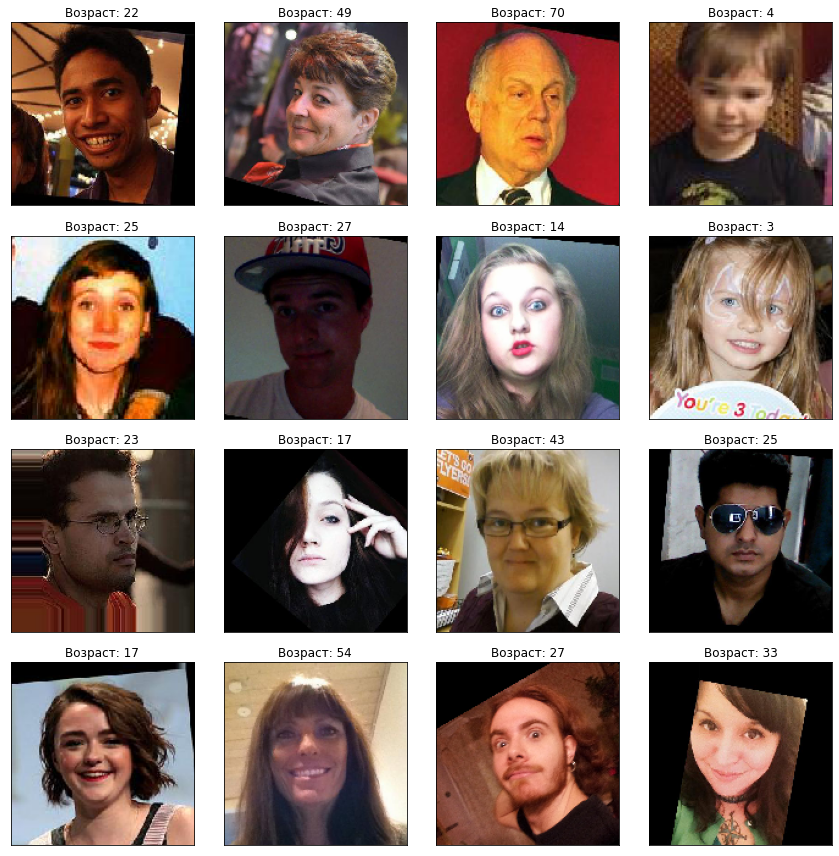

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
    ax.imshow(feature[i])
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_title(f'Возраст: {age[i]}')
plt.tight_layout() 
plt.show()

Как  и предполагалось в наборе содержится 7591 фотография.

В рамках проекта по созданию модели для распознавания возраста покупателей, мы предлагаем установить разумную нижнюю возрастную границу потенциальных клиентов на уровне 7 лет. Это обусловлено тем, что дети младше этого возраста обычно не совершают самостоятельные покупки.

Количество наблюдений для покупателей, чей возраст превышает 72 года, невелико. Этот возрастный диапазон представляет собой выбросы данных, и использование этих наблюдений для обучения модели может негативно сказаться на точности прогнозирования.

Предлагаем ограничить выборку возрастной группой от 7 до 72 лет.Это позволит создать модель с более высокой точностью прогнозирования и учесть типичные возрастные категории покупателей.

Заказчику будет предложено провести обучение на одном из 3 датасетов:
- исходный `df_labels`
- c возрастным диапазоном (7-72 года) `df_labels_7_to_72`
- с возрастным диапазоном (7-100 лет) `df_labels_7_to_100`

In [36]:
df_labels_7_to_72 = df_labels.query('real_age>=7 and real_age<=72')
df_labels_7_to_72.describe()

,real_age
count,6904.000000
mean,32.053737
std,14.088466
min,7.000000
25%,22.000000
50%,30.000000
75%,41.000000
max,72.000000


In [37]:
df_labels_7_to_72 = df_labels.query('real_age>=7')
df_labels_7_to_72.describe()

,real_age
count,7073.000000
mean,33.253358
std,15.922110
min,7.000000
25%,22.000000
50%,30.000000
75%,42.000000
max,100.000000


**Выводы**

Для решения задачи определения возратста человека был предоставлен набор фотографий и соответствующие им возрастные метки, общим количеством  7591. Был проведен исследовательский анализ,  в результате  которого  были подготовлены  два датасета `df_labels_7_to_72` c возрастным диапазоном 7-72 года и
`df_labels_7_to_100` с возрастным диапазонам. Также были напечатаны  16 случайных фотографий размером
(150,150) для ознакомления.



Общие характеристики  `df_labels`:
- Общее количество наблюдений составило 7591.
- Диапазон возрастов в данных колеблется от 1 до 100 лет.
- Среднее значение возраста составляет 31 год, а медиана — 29 лет.
- Стандартное отклонение равно 17 годам. 

Общие характеристики  `df_labels_7_to_72`:
- Общее количество наблюдений составило 6904.
- Диапазон возрастов в данных колеблется от 7 до 72 лет.
- Среднее значение возраста составляет 32 год, а медиана — 30 лет.
- Стандартное отклонение равно 14 годам. 

Общие характеристики  `df_labels_7_to_100`:
- Общее количество наблюдений составило 7073.
- Диапазон возрастов в данных колеблется от 7 до 100 лет.
- Среднее значение возраста составляет 33 год, а медиана — 30 лет.
- Стандартное отклонение равно 16 годам. 

Все три и датасета включают дастаточное количество наблюдений для обучения модели.

**Обучим модель на общем датасете df_labels.  
В случае, если не удается достичь требуемого качества обучения с MAE < 7, мы перейдем к использованию датасета df_labels_7_to_100.  В случае затруднений с достижением целевых значений, используем df_labels_7_to_72**.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


from  tensorflow import keras
import numpy as np
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications.resnet import ResNet50 # type: ignore
import pandas as pd



def load_train (path):

    df_labels =pd.read_csv(path+'labels.csv')

    gen_train= ImageDataGenerator(validation_split=0.25,
                                  rescale=1/255,
                                 horizontal_flip=True)
                                #  vertical_flip=True)
                                # rotation_range=90)
                                #   width_shift_range=0.2,
                                #   height_shift_range=0.2)
    
    foto_gen = gen_train.flow_from_dataframe( 
        dataframe = df_labels,
        directory= path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150,150),
        subset='training',
       batch_size=16,
    seed = 50
    )
    return  foto_gen


def load_test (path):

    df_labels =pd.read_csv(path+'labels.csv')

    gen_train= ImageDataGenerator(validation_split=0.25,
                                  rescale=1/255)
                                
    foto_gen = gen_train.flow_from_dataframe( 
        dataframe = df_labels,
        directory= path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150,150),
        subset='validation',
       batch_size=16,
       seed = 50
      )
    return  foto_gen  

def create_model(input_shape):
    optimizer = Adam(0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    # weights='imagenet',
                    include_top=False)
    # backbone.trainable = False
    model = keras.models.Sequential()
    model.add(backbone)
    model.add(keras.layers.GlobalAveragePooling2D())
    # model.add(keras.layers.Dense(units=240, activation='relu'))
    model.add(keras.layers.Dense(units=120, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data,  batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):
     
     model.fit(train_data,
               validation_data=test_data,
               epochs=epochs,
               batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
     return model 

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/30
2024-07-04 19:47:29.377630: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-04 19:47:29.756397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 61s - loss: 191.9843 - mae: 10.2805 - val_loss: 741.3836 - val_mae: 22.2011
Epoch 2/30
356/356 - 50s - loss: 80.9652 - mae: 6.8926 - val_loss: 155.8846 - val_mae: 9.4734
Epoch 3/30
356/356 - 49s - loss: 53.4860 - mae: 5.6206 - val_loss: 80.4555 - val_mae: 6.7526
Epoch 4/30
356/356 - 44s - loss: 38.2623 - mae: 4.7020 - val_loss: 89.4280 - val_mae: 7.4731
Epoch 5/30
356/356 - 44s - loss: 27.4603 - mae: 3.9871 - val_loss: 100.0276 - val_mae: 7.3145
Epoch 6/30
356/356 - 45s - loss: 21.0105 - mae: 3.5007 - val_loss: 71.6952 - val_mae: 6.4267
Epoch 7/30
356/356 - 48s - loss: 17.0297 - mae: 3.1211 - val_loss: 76.7145 - val_mae: 6.4290
Epoch 8/30
356/356 - 49s - loss: 15.0243 - mae: 2.9456 - val_loss: 74.6455 - val_mae: 6.3871
Epoch 9/30
356/356 - 50s - loss: 13.7662 - mae: 2.8032 - val_loss: 76.9449 - val_mae: 6.7497
Epoch 10/30
356/356 - 49s - loss: 12.3157 - mae: 2.6249 - val_loss: 72.6985 - val_mae: 6.2861
Epoch 11/30
356/356 - 49s - loss: 13.9043 - mae: 2.8144 - val_loss: 77.5569 - val_mae: 6.7134
Epoch 12/30
356/356 - 50s - loss: 14.3833 - mae: 2.8103 - val_loss: 80.0366 - val_mae: 6.6738
Epoch 13/30
356/356 - 50s - loss: 14.3823 - mae: 2.8852 - val_loss: 81.1750 - val_mae: 6.6283
Epoch 14/30
356/356 - 50s - loss: 12.8397 - mae: 2.7267 - val_loss: 69.6629 - val_mae: 6.3424
Epoch 15/30
356/356 - 49s - loss: 11.6591 - mae: 2.6011 - val_loss: 74.4167 - val_mae: 6.4098
Epoch 16/30
356/356 - 49s - loss: 11.1425 - mae: 2.5232 - val_loss: 68.8177 - val_mae: 6.2970
Epoch 17/30
356/356 - 49s - loss: 10.6459 - mae: 2.4716 - val_loss: 68.4332 - val_mae: 6.3103
Epoch 18/30
356/356 - 49s - loss: 10.3105 - mae: 2.4303 - val_loss: 83.8910 - val_mae: 6.7260
Epoch 19/30
356/356 - 48s - loss: 9.7733 - mae: 2.3584 - val_loss: 75.2086 - val_mae: 6.7046
Epoch 20/30
356/356 - 42s - loss: 9.3631 - mae: 2.3167 - val_loss: 70.1214 - val_mae: 6.2456
Epoch 21/30
356/356 - 42s - loss: 9.4368 - mae: 2.3236 - val_loss: 64.8551 - val_mae: 6.0045
Epoch 22/30
356/356 - 42s - loss: 8.7713 - mae: 2.2475 - val_loss: 69.9495 - val_mae: 6.2527
Epoch 23/30
356/356 - 42s - loss: 8.8369 - mae: 2.2355 - val_loss: 71.8297 - val_mae: 6.1434
Epoch 24/30
356/356 - 42s - loss: 8.5740 - mae: 2.2161 - val_loss: 78.0469 - val_mae: 6.4991
Epoch 25/30
356/356 - 42s - loss: 8.7800 - mae: 2.2100 - val_loss: 70.8714 - val_mae: 6.3262
Epoch 26/30
356/356 - 42s - loss: 8.2080 - mae: 2.1536 - val_loss: 64.7398 - val_mae: 6.2001
Epoch 27/30
356/356 - 42s - loss: 7.5635 - mae: 2.0498 - val_loss: 73.8629 - val_mae: 6.6611
Epoch 28/30
356/356 - 42s - loss: 6.9271 - mae: 1.9940 - val_loss: 64.7997 - val_mae: 5.9790
Epoch 29/30
356/356 - 42s - loss: 7.0738 - mae: 1.9928 - val_loss: 69.7139 - val_mae: 6.1381
Epoch 30/30
356/356 - 42s - loss: 7.3766 - mae: 2.0111 - val_loss: 66.4508 - val_mae: 6.1711
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 66.4508 - mae: 6.1711
Test MAE: 6.1711

```

## Анализ обученной модели

Для решения задачи  регрессии  по  определению  возрасты человека  по фотографии мы использовали  предобученную сеть
ResNet50, добавив  в нее 3 слоя:
- keras.layers.GlobalAveragePooling2D();
- keras.layers.Dense(units=120, activation='relu';
- keras.layers.Dense(units=1, activation='relu'.

Модель была скомпилированна  на  функции потерь 'MSE' оптимизаторе Adam, метрикой оценки качества  выбрана 'MAE'

Ознакомимся  с архитектурой модели:

In [38]:

def create_model(input_shape):
    optimizer = Adam(0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    # weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    weights='imagenet',
                    include_top=False)
    # backbone.trainable = False
    model = keras.models.Sequential()
    model.add(backbone)
    model.add(keras.layers.GlobalAveragePooling2D())
    # model.add(keras.layers.Dense(units=240, activation='relu'))
    model.add(keras.layers.Dense(units=120, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [39]:
model = create_model(input_shape=(150,150,3))
model.summary()

2024-07-05 09:59:43.890206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


94781440/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                                 
Total params: 23,833,713
Trainable params: 23,780,593
Non-trainable params: 53,120
_________________________________________________________________


In [46]:
print(f'Входной тензор:{model.inputs}')


Входной тензор:[<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'resnet50_input')>]


Обучение производилось  на датасете `df_labels` размером  7591 фотография  с целевым признаком  возраста  в диапазоне от 1 до
100лет.
Данные  загружались  батчами,  размерность входного тензора (16, 150, 150, 3).
Для загрузки использовался ImageDataGenerator.

Модель обучалась в течение 30 эпох.

**В  результате  мы получили обученную модель, показавшую  MAE=6.17 , функция потерь Loss=66.45.**

**Полученные  результаты  согласуются с целевыми значениями, установленными в проекте.**

Модель была разработана для решения двух задач:
- Рекомендации покупателям на основании их возраста и анализа покупок;
- контроль добросовестности кассиров при продаже алкоголя.

Первая задача может быть решена с использованием предсказаний модели, которая определяет возраст покупателей. Для этого
нужно провести категоризацию покупателей по возрастным  критериям. На основе анализа покупок и возрастной категории можно подготавливать персонализированные рекомендации.


Вторая задача также может быть решена с помощью этой модели, для этого надо установить возрастной порог для контроля, 
однако для повышения точности мы рекомендуем разработать дополнительную модель для бинарной классификации.

Такая модель позволит более точно предсказывать категорию для которой необходим возрастной контроль, используя соответствующий возрастной порог и метрику 'recall'. Метрика 'recall' позволит точнее определить тех покупателей, для которых необходим возрастной контроль.

    